
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 1 <br>
<font color=696880 size=4>
    Niloufar Abbasi 

____

# Emotion Recognition with Recurrent Neural Networks


---

## **Introduction**

In this task, you will implement a Recurrent Neural Network (RNN) to perform tweet emotion recognition. The goal is to classify tweets into one of six basic emotions: 
- **0: sadness**
- **1: joy**
- **2: love**
- **3: anger**
- **4: fear**
- **5: surprise**

We will be using a dataset of tweets, where each tweet has been labeled with one of these emotions. Throughout this notebook, you will follow step-by-step instructions to build and train your model. As you progress, you'll complete the provided TODO sections by filling in the necessary code and functions.

By the end of this exercise, you will:
- Understand how to preprocess text data for use in RNN models.
- Build and train a model using Pytorch.
- Evaluate the performance of your model on the test set.

---


---

## Task 1: Enter Your Information

Before we begin, please enter your **student ID** and **name** in the code section below.

Make sure to replace the placeholders with your actual information.

---

In [2]:
#########################################
# TODO: Enter your personal information #
#########################################

student_name = "ahmadrezamajlesara"
student_id   = 400101861

print("Your name:", student_name)
print("Your student ID:", student_id)

Your name: ahmadrezamajlesara
Your student ID: 400101861


---

## Task 2: Setup and Imports

In this task, we'll be preparing our environment by importing the necessary libraries. Please run the cells below to set everything up. If any library is missing on your end, make sure to install it.

### Instructions:
1. **Run the cells** to install any required packages and import the necessary libraries.
2. If any library is not installed in your environment, use `!pip install <library_name>` to install it.
---

In [3]:
!pip install datasets

Required Libraries:

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

#####################################################################
# TODO: Add any additional libraries you may need for your analysis #
#####################################################################
 
# You can add your libraries here

### Additional Functions

The following functions have been provided to help you visualize the results of your model training. These will allow you to analyze both the model's performance over time (through the training history) and how well it performs on individual predictions (through a confusion matrix).

1. **`plot_history(hist)`**: This function takes the training history object (`hist`) from your model and plots both the accuracy and loss over the number of epochs for both training and validation sets. It provides an easy way to visually track the model's learning progress and performance.

2. **`visualize_confusion_matrix(actual_labels, predicted_labels, classes)`**: After making predictions with your model, you can use this function to plot a confusion matrix. It shows the accuracy of your model across each class, helping to identify areas where the model is performing well and where it might be struggling. The matrix is normalized to make comparisons easier.

These functions are for your convenience, you can directly use them after running your model to visualize the results.


In [4]:
# Functions to visualize training history and confusion matrix
def plot_history(hist):
    epochs = len(hist['loss'])
    plt.figure(figsize=(16, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), hist['accuracy'], label='Training')
    plt.plot(range(1, epochs + 1), hist['val_accuracy'], label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), hist['loss'], label='Training')
    plt.plot(range(1, epochs + 1), hist['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

def visualize_confusion_matrix(actual_labels, predicted_labels, classes):

    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


---

## Task 3: Importing Data

In this task, we will

- import the Tweet Emotion dataset

- create training, validation, and test sets
    
- extract the tweets and their corresponding labels for further analysis

---

In [5]:
dataset = load_dataset('emotion')
dataset

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
# Display the first few samples
print(dataset['train'][0:5])  # Adjust 'train' to 'test' or other splits if necessary

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [7]:
###########################################################################
# TODO: Create variables for the training, validation, and test datasets. #
###########################################################################

training = dataset['train']
validation = dataset['validation']
test = dataset['test']

In [8]:
########################################################################################################
# TODO:                                                                                                #
# Implement the `extract_tweets_labels` function to iterate over the provided dataset.                 #
# Within this function, extract the tweet text and their corresponding labels into two separate lists. #
# Then, call this function with the training dataset to obtain the tweets and labels,                  #
# ensuring proper data handling for subsequent analysis.                                               #
########################################################################################################

def extract_tweets_labels(data):
    # Extract the text and labels from the data
    tweets = [item['text'] for item in data]
    labels = [item['label'] for item in data]
    return tweets, labels

# Get the tweets and labels from the training set
tweets, labels = extract_tweets_labels(training)

# Display the first tweet and its label
print(tweets[0], labels[0])


i didnt feel humiliated 0


---

## Task 4: Tokenization of Tweets

In this section, we will focus on the tokenization of the tweets in the dataset. Tokenization is a crucial step in natural language processing (NLP) that involves breaking down text into smaller units, such as words or subwords. This process enables the model to better understand and analyze the text data.

### Objectives:
1. Implement a tokenizer to convert the tweet texts into tokens.
2. Ensure the tokenization process handles various aspects of the text, such as punctuation and special characters.

By the end of this task, you will have a set of tokenized tweets ready for further processing in your NLP pipeline.

---

In [9]:

###############################################################################################################################################
# TODO: Tokenization of Tweets                                                                                                                #
# 1. Select a Tokenization Method: Choose a suitable tokenization method to preprocess the tweets.                                            #                                 
# Ensure that the tokenization handles special characters and maintains the integrity of the text data.                                       #
# 2. Implement the Tokenizer: Once you have selected a method, implement the tokenizer to convert the tweet texts into sequences of tokens.   #
# 3. Test the Tokenization:                                                                                                                   #
# Verify the functionality of your tokenizer by applying it to a sample tweet from the dataset and displaying the resulting tokenized output. #
###############################################################################################################################################

# Step 1: Select and load the tokenizer (using a pre-trained tokenizer)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Step 2: Implement the tokenizer function
def tokenize_tweet(tweet):
    # Tokenize the tweet
    tokens = tokenizer.tokenize(tweet)
    return tokens

# Step 3: Test the tokenization
sample_tweet = tweets[0]  # Taking the first tweet from the training set
tokenized_output = tokenize_tweet(sample_tweet)

# Display the sample tweet and its tokenized version
print("Original Tweet:", sample_tweet)
print("Tokenized Output:", tokenized_output)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Original Tweet: i didnt feel humiliated
Tokenized Output: ['i', 'didn', '##t', 'feel', 'humiliated']


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


---

## Task 5: Padding and Truncating Sequences

In this task, we will prepare the tokenized tweets for model training by checking their lengths and creating padded sequences.

1. **Checking the Length of the Tweets**
   - Analyze the distribution of tweet lengths to understand the range of token counts in the dataset.

2. **Creating Padded Sequences**
   - After tokenizing the tweets, sequences of different lengths must be adjusted to a uniform length to facilitate training.

---


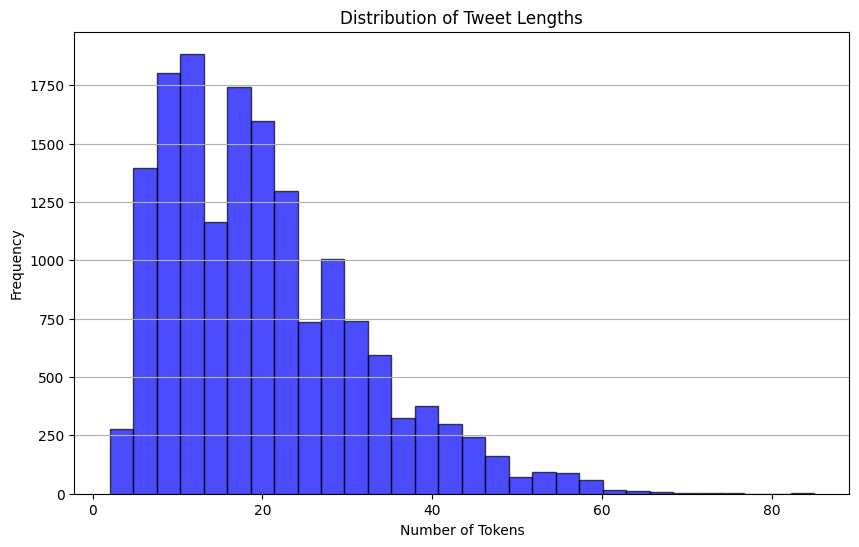

Minimum tweet length: 2
Maximum tweet length: 85
Mean tweet length: 20.2595
Median tweet length: 18.0


In [10]:
#####################################################################################################################################################
# TODO:                                                                                                                                             #
# Implement code to calculate the lengths of the tweets and visualize the distribution using a histogram. Use an appropriate visualization library. #
# After visualizing the distribution, determine a suitable maximum length for padding and truncating the sequences based on your findings.          #
#####################################################################################################################################################

# Calculate the lengths of the tokenized tweets
tweet_lengths = [len(tokenize_tweet(tweet)) for tweet in tweets]

# Visualize the distribution of tweet lengths
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

# Determine a suitable maximum length for padding/truncating
# Print some statistics to help decide
print("Minimum tweet length:", min(tweet_lengths))
print("Maximum tweet length:", max(tweet_lengths))
print("Mean tweet length:", np.mean(tweet_lengths))
print("Median tweet length:", np.median(tweet_lengths))

In [11]:
############################################################################################################
# TODO: Define a function to convert the tokenized tweets into sequences and apply padding and truncation. # 
# Use your determined maximum length for padding the sequences.                                            #
############################################################################################################

def get_sequences(tokenizer, tweets, max_length):
    sequences = [tokenizer.convert_tokens_to_ids(tokenize_tweet(tweet)) for tweet in tweets]
    
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    
    return padded_sequences

max_length = 85

padded_train_sequences = get_sequences(tokenizer, tweets, max_length)

print(padded_train_sequences[0])

[ 1045  2134  2102  2514 26608     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]


---

## Task 6: Analyzing Label Distribution

1. Checking the distribution of labels.
2. Addressing any class imbalance using appropriate techniques.

Note:

(**Providing a clear explanation of the chosen method to address the imbalance and how it will improve the model’s performance is critical.** Without handling class imbalance properly, the model could achieve a high accuracy by focusing on the majority class, but it may perform poorly on the minority class, which would result in misleading metrics and reduced generalization.

Hence, it is important to not only implement an appropriate solution but also **justify** why the selected approach is effective for the given task.)

---

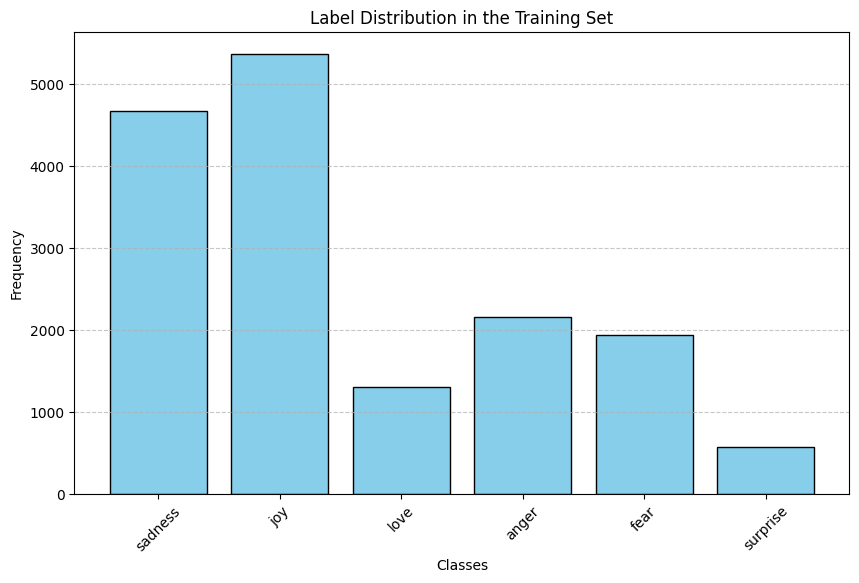

Label Distribution: Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})
New Label Distribution after Oversampling: Counter({0: 5362, 3: 5362, 2: 5362, 5: 5362, 4: 5362, 1: 5362})


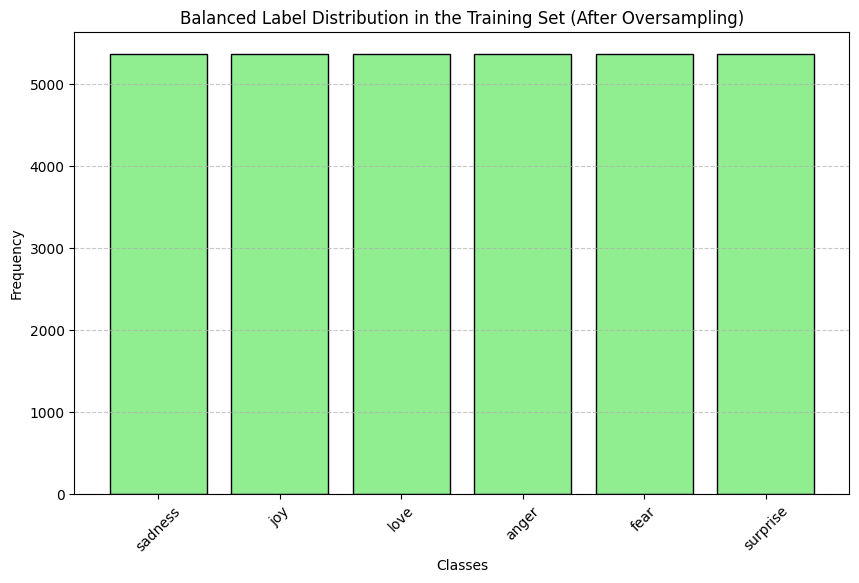

In [12]:
##########################################################################################################################
# TODO: Analyze the distribution of labels in the training set. (visualize it in a perfect way)                          #
# Determine if there is any class imbalance.                                                                             #
# If you observe any imbalance, apply one of the techniques you have learned throughout the course to address the issue. #
##########################################################################################################################

label_counts = Counter(labels)
classes = dataset['train'].features['label'].names

plt.figure(figsize=(10, 6))
plt.bar(classes, [label_counts[i] for i in range(len(classes))], color='skyblue', edgecolor='black')
plt.title("Label Distribution in the Training Set")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Label Distribution:", label_counts)

labels_array = np.array(labels)

oversampler = RandomOverSampler(random_state=42)
balanced_tweets, balanced_labels = oversampler.fit_resample(np.array(tweets).reshape(-1, 1), labels_array)

balanced_tweets = balanced_tweets.flatten()

balanced_label_counts = Counter(balanced_labels)
print("New Label Distribution after Oversampling:", balanced_label_counts)

plt.figure(figsize=(10, 6))
plt.bar(classes, [balanced_label_counts[i] for i in range(len(classes))], color='lightgreen', edgecolor='black')
plt.title("Balanced Label Distribution in the Training Set (After Oversampling)")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

---

## Task 7: Creating the Model

Design and implement a recurrent neural network for the task. You may utilize a sequential architecture like RNN or GRU to enhance the model's performance.

Build and compile your model using Pytorch.

**Once the model is created, summarize its structure to verify the design.**

---

In [13]:
#########################################################################################################
# TODO:                                                                                                 #
# Create a recurrent neural network model for the task.                                                 #
# (Suggestion: Implement a Bidirectional LSTM architecture to process the input sequences effectively.) #
# Once the model is created, summarize its structure to verify the design.                              #
#########################################################################################################

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            bidirectional=True, 
            batch_first=True, 
            dropout=dropout
        )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 because bidirectional
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Pass through embedding layer
        embedded = self.embedding(x)
        
        # Pass through LSTM layer
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Concatenate the forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        # Pass through dropout and fully connected layer
        output = self.dropout(hidden)
        output = self.fc(output)
        
        return output

# Hyperparameters
vocab_size = len(tokenizer.vocab)  # Vocabulary size from tokenizer
embedding_dim = 100  # Embedding dimension
hidden_dim = 128  # Hidden size of LSTM
output_dim = len(classes)  # Number of output classes
num_layers = 2  # Number of LSTM layers
dropout = 0.3  # Dropout rate

# Create the model
model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)

# Summarize the model structure
print(model)

BiLSTMModel(
  (embedding): Embedding(30522, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


---

## Task 8: Training the Model

In this task, you will prepare a validation set and train your model using the training data.

1. Prepare the validation set by extracting tweets and labels, and convert them into sequences using the tokenizer.
2. Train the model on the training data.
3. Ensure that you implement **Early Stopping** to prevent overfitting and enhance efficiency.

Make sure to monitor the validation accuracy during training and adjust the parameters as necessary.

---

In [14]:
###############################################################################################################
# TODO: Extract the tweets and labels from the validation set. Convert the tweets into sequences using the    #
#       tokenizer defined earlier. Prepare the data for validation and ensure it matches the format of the    #
#       training set.                                                                                         #
###############################################################################################################

# Your code for extracting and processing validation data goes here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device being used
print(f"Using device: {device}")

# Move the model to the selected device
model = model.to(device)
# Extract validation tweets and labels
val_tweets, val_labels = extract_tweets_labels(validation)

# Convert tweets into sequences
padded_val_sequences = get_sequences(tokenizer, val_tweets, max_length)

# Convert to PyTorch tensors
val_sequences_tensor = torch.tensor(padded_val_sequences).to(device)
val_labels_tensor = torch.tensor(val_labels).to(device)

# Create DataLoader for validation data
val_data = TensorDataset(val_sequences_tensor, val_labels_tensor)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
###############################################################################################################
# TODO: Train the model on the prepared training data. Ensure you implement early stopping to monitor the     #
#       validation accuracy and prevent overfitting. Adjust the number of epochs or other hyperparameters as  #
#       needed to optimize model performance.                                                                 #
###############################################################################################################

# Your code for training the model with early stopping goes here
# Set the device to GPU if available, otherwise fall back to CPU

epochs = 20
learning_rate = 0.001
batch_size = 32
patience = 3  # Early stopping patience

# Prepare training data
padded_train_sequences = get_sequences(tokenizer, tweets, max_length)
train_sequences_tensor = torch.tensor(padded_train_sequences).to(device)
train_labels_tensor = torch.tensor(labels).to(device)

train_data = TensorDataset(train_sequences_tensor, train_labels_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping variables
best_val_loss = float('inf')
early_stop_counter = 0

# Training loop
# Initialize arrays to store metrics
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct, total = 0, 0

    # Training step
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    train_accuracy = correct / total
    training_losses.append(train_loss / len(train_loader))
    training_accuracies.append(train_accuracy)

    # Validation step
    model.eval()
    val_loss = 0
    correct, total = 0, 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    val_accuracy = correct / total
    validation_losses.append(val_loss / len(val_loader))
    validation_accuracies.append(val_accuracy)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Training Loss: {training_losses[-1]:.4f} | Training Accuracy: {training_accuracies[-1]:.4f}")
    print(f"Validation Loss: {validation_losses[-1]:.4f} | Validation Accuracy: {validation_accuracies[-1]:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break


Using device: cuda
Epoch 1/20
Training Loss: 1.3877 | Training Accuracy: 0.4614
Validation Loss: 0.9646 | Validation Accuracy: 0.6620
Epoch 2/20
Training Loss: 0.7129 | Training Accuracy: 0.7571
Validation Loss: 0.5798 | Validation Accuracy: 0.8035
Epoch 3/20
Training Loss: 0.3663 | Training Accuracy: 0.8743
Validation Loss: 0.3677 | Validation Accuracy: 0.8755
Epoch 4/20
Training Loss: 0.2084 | Training Accuracy: 0.9250
Validation Loss: 0.3084 | Validation Accuracy: 0.8915
Epoch 5/20
Training Loss: 0.1472 | Training Accuracy: 0.9427
Validation Loss: 0.2776 | Validation Accuracy: 0.9035
Epoch 6/20
Training Loss: 0.1085 | Training Accuracy: 0.9557
Validation Loss: 0.2843 | Validation Accuracy: 0.9085
Epoch 7/20
Training Loss: 0.0898 | Training Accuracy: 0.9669
Validation Loss: 0.2866 | Validation Accuracy: 0.9065
Epoch 8/20
Training Loss: 0.0760 | Training Accuracy: 0.9694
Validation Loss: 0.2945 | Validation Accuracy: 0.9050
Early stopping triggered.


---

## Task 9: Evaluating the Model

In this task, you will evaluate the performance of your model on the test set and visualize the training history. You will also analyze the model’s predictions on both individual and complete test samples.

### Steps:
1. Visualize the loss and accuracy over the training epochs.
2. Prepare and preprocess the test data using functions from Task 2.
3. Evaluate the model on the test set and examine individual predictions.
4. Analyze the overall predictions and display a confusion matrix.

---

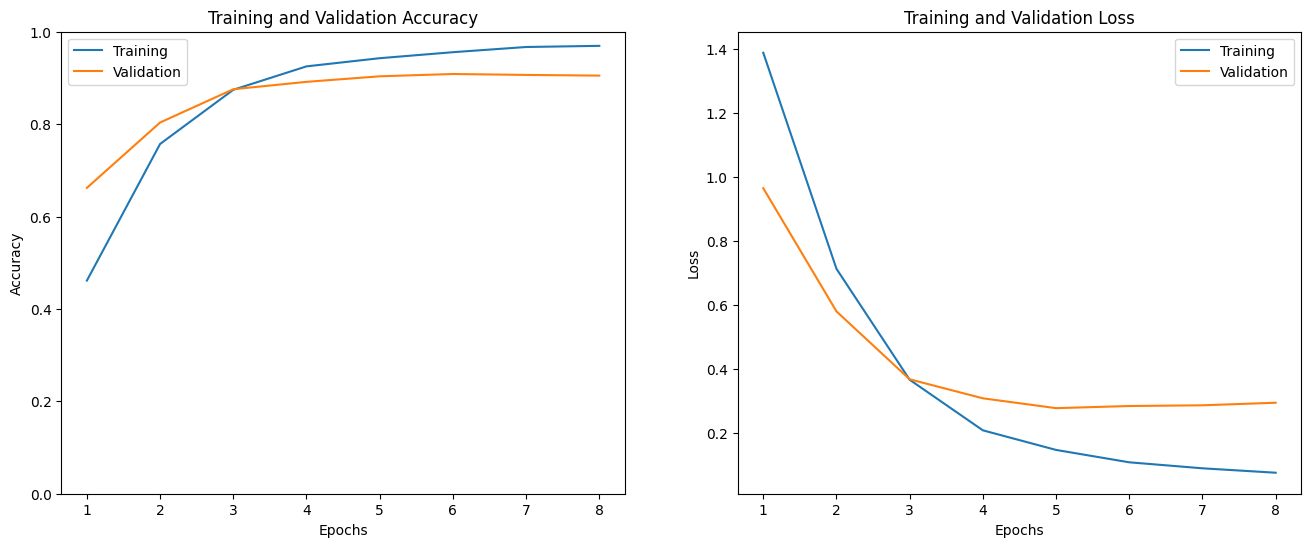

In [15]:
###############################################################################################################
# TODO: Visualize the training history by plotting the loss and accuracy over the epochs to assess model      #
#       performance. Use an appropriate visualization method to ensure clarity and effectiveness.             #
#       you can use function implemented in Task 2 for your visualizations                                    #
###############################################################################################################

# Your code for visualizing the training history goes here
###############################################################################################################
# TODO: Visualize the training history by plotting the loss and accuracy over the epochs to assess model      #
#       performance. Use an appropriate visualization method to ensure clarity and effectiveness.             #
#       you can use function implemented in Task 2 for your visualizations                                    #
###############################################################################################################

# Prepare history dictionary compatible with the plot_history function
history = {
    'loss': training_losses,
    'accuracy': training_accuracies,
    'val_loss': validation_losses,
    'val_accuracy': validation_accuracies
}
plot_history(history)

In [16]:
###############################################################################################################
# TODO: Prepare the test set by extracting the tweets and labels, then convert the tweets into sequences using #
#       the tokenizer. Ensure the format matches that of the training and validation sets.                     #
###############################################################################################################

test_tweets, test_labels = extract_tweets_labels(test)

padded_test_sequences = get_sequences(tokenizer, test_tweets, max_length)

test_sequences_tensor = torch.tensor(padded_test_sequences).to(device)
test_labels_tensor = torch.tensor(test_labels).to(device)

test_data = TensorDataset(test_sequences_tensor, test_labels_tensor)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print("Test set is prepared. Number of samples:", len(test_tweets))

Test set is prepared. Number of samples: 2000


In [17]:
###############################################################################################################
# TODO: Evaluate the model's performance on the test set. Print the accuracy and loss, and review individual   #
#       predictions to understand how the model is performing on unseen data.                                 #
###############################################################################################################

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
            
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    
    accuracy = correct / total
    avg_loss = test_loss / len(test_loader)
    return avg_loss, accuracy, predictions, actuals

# Evaluate the model
test_loss, test_accuracy, test_predictions, test_actuals = evaluate_model(model, test_loader)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Review individual predictions
print("\nSample Predictions:")
for i in range(5):  # Display first 5 predictions
    print(f"Tweet: {test_tweets[i]}")
    print(f"Actual Label: {classes[test_actuals[i]]}, Predicted Label: {classes[test_predictions[i]]}")
    print("-" * 50)

Test Loss: 0.3322
Test Accuracy: 0.9035

Sample Predictions:
Tweet: im feeling rather rotten so im not very ambitious right now
Actual Label: sadness, Predicted Label: sadness
--------------------------------------------------
Tweet: im updating my blog because i feel shitty
Actual Label: sadness, Predicted Label: sadness
--------------------------------------------------
Tweet: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
Actual Label: sadness, Predicted Label: sadness
--------------------------------------------------
Tweet: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
Actual Label: joy, Predicted Label: joy
--------------------------------------------------
Tweet: i was feeling a little vain when i did this one
Actual Label: sadness, Predicted Label: sadness
--------------------------------------------------


Confusion Matrix:


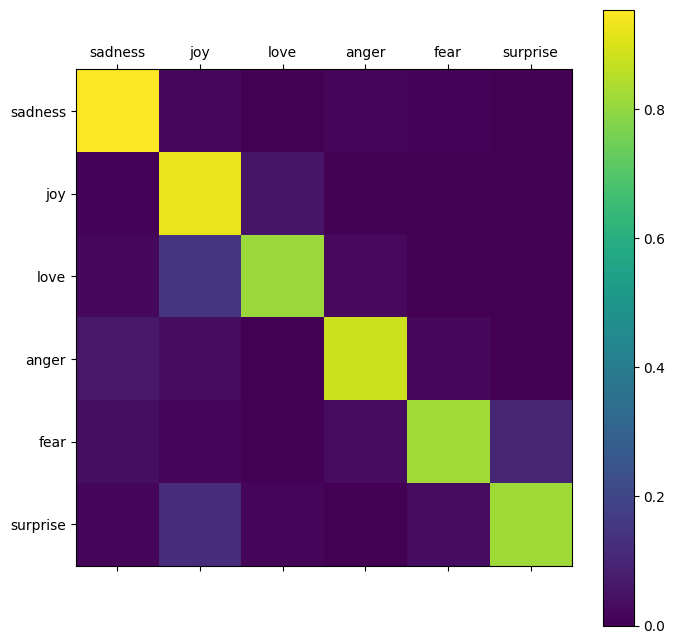

In [18]:
###############################################################################################################
# TODO: Generate predictions for all test samples and analyze the model's overall performance. Display the     #
#       confusion matrix to visualize the differences between true and predicted labels, helping to interpret  #
#       the model's classification results.                                                                   #
###############################################################################################################

print("Confusion Matrix:")
visualize_confusion_matrix(test_actuals, test_predictions, classes)

# Final Analysis

After visualizing the confusion matrix based on your model’s predictions, analyze the results and provide insights into the model’s classification performance.

### **Question:**
<span style="font-size: 1.2em;">Which class seems to get confused with the class *love* the most?</span>

**Remember the class labels:**
- **0:** *Sadness*
- **1:** *Joy*
- **2:** *Love*
- **3:** *Anger*
- **4:** *Fear*
- **5:** *Surprise*

Reflect on the confusion matrix to answer this question and provide your reasoning for why this confusion might occur based on the emotional nature of the classes.


The confusion matrix shows that the model performs well for emotions like sadness, anger, and fear but struggles with love and joy. Love is often misclassified as joy, and joy as love, likely because these emotions share subtle and overlapping features, making them challenging to separate. Despite the data being balanced, the model may still have difficulty capturing the unique patterns or signals that distinguish these closely related emotions. This could be due to limitations in the feature representation or the complexity of the emotions themselves. Refining the feature extraction process or using more expressive models might help improve the distinction between these emotions.

# **Best regards.**